In [1]:
#import libraries
import os
from PIL import Image as PImage
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import numpy as np
from timeit import default_timer as timer
import random
from IPython.display import clear_output
import h5py

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def chopnb(expr, *, max=10**-10): #defining chop function to reduce very small values to 0 in arrays
    return [i if abs(i) > max else 0 for i in expr]

def abbs(expr): #defining abs function for arrays
    return [abs(i) for i in expr]

# We had faulty images in our dataset, so we wrote a function to determine if an image is faulty.
# A faulty image had same colour vertical stripes in the first or last 5 rows or colums
# The algorithm works by calculating the deviation of each vertical or 
# horizontal stripe, and summing the deviations up.
def faulty(args):
    dev = np.zeros(4)
    val = np.zeros(4) 
    err = 5                  # We check on the first 5 pixels from edge if stripes exist
    errp = args.shape[1]-err #and on the last 5 pixels
    for i in range(args.shape[1]):
        for j in range(3):
            # calculate deviation of each edge of image
            val[0] = np.std(args[errp:,i,j]) 
            val[1] = np.std(args[:err,i,j])
            val[2] = np.std(args[i,errp:,j])
            val[3] = np.std(args[i,:err,j])
   
            # I needed to add a small activation limit because std gives small numbers (e-15) for a list
            chopnb(val) 
            dev += val  #even if it contains the same elements (numerical error during calculation)
            
     #if the 0-err (0-5) and the errp-lastpixel (123-128) pixelrange does not contain stripes then:
    if (dev[0] != 0 and dev[1] != 0 and dev[2] != 0 and dev[3] != 0):
        return 0
    else:
        return 1

# checks if the picture is colorful enough
def isColored(lab_img):
    average = (np.sum(abbs(lab_img[:,:,1])) + np.sum(abbs(lab_img[:,:,2])))/(2*lab_img.shape[0]*lab_img.shape[1])
    std = np.std(lab_img[:,:,1:3])
    if average > 5 and std > 5:
        return True
    else:
        return False
    
#function to crop a picture to a square shape, with cropping the edges, and getting the middle back
def cropmid(img):
    if(img.size[0]!= img.size[1]): #check if img needs cropping in the first place
        xfrom = int((img.size[0]-min(img.size))/2) # we crop from here
        xto = xfrom+min(img.size)                  #til here
        yfrom = int((img.size[1]-min(img.size))/2)
        yto = yfrom+min(img.size)
    
        return img.crop((xfrom,yfrom,xto,yto))
    else:
        return img

In [3]:
# image_list - a list containing the relative pathes to the images
# start/end_index - the working area of image_list (training data will be easily upgradable)
# outsize - size of output pictures
def dataprep(image_list, start_index, end_index, outsize = 128, save_dir = 'data/processed_images'):
    # creating folder for storing good pictures
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # set index in range of number of images
    if end_index < 0 or end_index > len(image_list):
        end_index = len(image_list)
        
    cc = 0        # good image count
    start = timer() # for measuring time

    for index in range(start_index,end_index):
        img = PImage.open(image_list[index]) # open image
        # check if size exceeds 128x128 because we dont want to upscale images
        if (img.size[0]>=outsize and img.size[1]>=outsize and img.format == 'JPEG'):
            img = cropmid(img).resize((outsize,outsize),resample=PImage.LANCZOS) # scale down image
            # change to np array from PIL.Image, we need the RGB conversion here to get array 
            # from pixel value tuple
            img_array = np.array(img.convert('RGB'))
            labp = np.round(rgb2lab(img_array))  # Convert image to LAB color-space
            # Check if image is not faulty and not greyscale
            if faulty(labp) == 0 and isColored(labp):
                cc += 1
                img.save(save_dir + '/portrait' + str(index) + '.jpg') # save image
        if ((index-start_index) % ((end_index-start_index)//100) == 0): # feedback
            clear_output()
            print(int((index-start_index)/(end_index-start_index)*100), '% has been processed!')
    end = timer()
    clear_output()
    print('From',end_index-start_index, 'processed pictures', cc, 'pictures was appropriate and saved to', save_dir,
          'directory.\n', 'Data preprocessing time:', end - start)

In [4]:
path = "imdb_crop/" #image folders directory
folderList = os.listdir(path)         #list of subfolders (names)
imagesList = []
for folder in folderList:          #list of images in subfolder
    if not '.' in folder:          # if it's not a file
        for img in os.listdir(path+folder):
            imagesList.append(path + folder + '/' + img)
random.seed(123) # set seed for repeatability
random.shuffle(imagesList) # shuffle datas

In [5]:
len(imagesList) # number of images

460723

In [208]:
dataprep(imagesList,50000,-1)

From 410723 processed pictures 215143 pictures was appropriate and saved to data/processed_images directory.
 Data preprocessing time: 20018.97500058348


In [4]:
# according to the split proportion splits data to separate folders
# from_dir: directory which contains pictures will be splitted
# train/valid/test _dir: directory where outputs will be saved to
# train/valid/test _split: split proportion
def split_data(from_dir, number = -1,  train_dir = 'data/train/dummy',
               valid_dir = 'data/valid/dummy', test_dir = 'data/test/dummy',
               train_split = 0.7, valid_split = 0.2, test_split = 0.1):
    # if the folder exists delete it with all of its content
    # this is needed to prevent mixing datas by calling this function more times
    if os.path.exists(train_dir):
        for file in os.listdir(train_dir):
            os.unlink(train_dir + '/' + file)
        os.rmdir(train_dir)
    if os.path.exists(valid_dir):
        for file in os.listdir(valid_dir):
            os.unlink(valid_dir + '/' + file)
        os.rmdir(valid_dir)
    if os.path.exists(test_dir):
        for file in os.listdir(test_dir):
            os.unlink(test_dir + '/' + file)
        os.rmdir(test_dir)
        
    # creating empty directories for output
    os.makedirs(train_dir)
    os.makedirs(valid_dir)
    os.makedirs(test_dir)
    
    summa = train_split + valid_split + test_split  #(for safety), only the proportion of the splits matter
    train_split /= summa
    valid_split /= summa
    test_split /= summa
    
    image_list = os.listdir(from_dir) # images' name
    
    nb = len(image_list) # number of pictures which will be processed
    if(number > 0 and nb > number): # if 'number' is in range of len of images
        nb = number
    
    # train
    for index in range(0, int(nb*train_split)):
        img = PImage.open(from_dir + '/' + image_list[index]) # open image
        img.save(train_dir + '/' + image_list[index]) # save image
    
    # valid
    for index in range(int(nb*train_split), int(nb*(train_split + valid_split))):
        img = PImage.open(from_dir + '/' + image_list[index]) # open image
        img.save(valid_dir + '/' + image_list[index]) # save image
        
    # test
    for index in range(int(nb*(train_split + valid_split)), nb):
        img = PImage.open(from_dir + '/' + image_list[index]) # open image
        img.save(test_dir + '/' + image_list[index]) # save image

In [10]:
split_data('data/processed_images', number = -1)

In [7]:
# according to the split proportion splits images to separate datasets in a single hdf5 file
# from_dir: directory which contains pictures will be splitted
# hdf5_path: path of the output file
# number: number of images which will be processed
# train/valid/test _name: name of the dataset in hdf5 file
# train/valid/test _split: split proportion
def create_hdf5(from_dir, hdf5_path, number = -1,
                train_name = 'train', valid_name = 'valid', test_name = 'test',
                train_split = 0.7, valid_split = 0.2, test_split = 0.1):
    
    summa = train_split + valid_split + test_split  #(for safety), only the proportion of the splits matter
    train_split /= summa
    valid_split /= summa
    test_split /= summa
    
    # calculate number of images will be processed
    image_list = os.listdir(from_dir)
    nb = len(image_list)
    if(number > 0 and nb > number):
        nb = number
    
    # calculating data shapes
    img = np.array(PImage.open(from_dir + '/' + image_list[0]))
    train_shape = (int(nb*train_split),img.shape[0],img.shape[1],img.shape[2])
    valid_shape = (int(nb*(train_split+valid_split)) - int(nb*train_split),img.shape[0],img.shape[1],img.shape[2])
    test_shape = (nb - int(nb*(train_split+valid_split)),img.shape[0],img.shape[1],img.shape[2])
    
    #debug
    print(train_shape)
    print(valid_shape)
    print(test_shape)
    
    # creating/overwriting hdf5file
    hdf5_file = h5py.File(hdf5_path, mode='w')
    
    # creating empty arrays
    # using 8bit type to save disk space
    hdf5_file.create_dataset(train_name, train_shape, np.int8)
    hdf5_file.create_dataset(valid_name, valid_shape, np.int8)
    hdf5_file.create_dataset(test_name, test_shape, np.int8)
    
    # train
    for index in range(0, int(nb*train_split)):
        img = PImage.open(from_dir + '/' + image_list[index]) # open image
        lab = np.round(rgb2lab(np.array(img).astype(np.uint8))).astype(np.int8) # convert to LAB
        hdf5_file[train_name][index, ...] = lab
        
    # valid
    for index in range(int(nb*train_split), int(nb*(train_split + valid_split))):
        img = PImage.open(from_dir + '/' + image_list[index]) # open image
        lab = np.round(rgb2lab(np.array(img).astype(np.uint8))).astype(np.int8) # convert to LAB
        hdf5_file[valid_name][index - train_shape[0], ...] = lab
        
    # test
    for index in range(int(nb*(train_split + valid_split)), nb):
        img = PImage.open(from_dir + '/' + image_list[index]) # open image
        lab = np.round(rgb2lab(np.array(img).astype(np.uint8))).astype(np.int8) # convert to LAB
        hdf5_file[test_name][index - train_shape[0] - valid_shape[0], ...] = lab
        
    hdf5_file.close() # closing file

In [99]:
create_hdf5('data/processed_images', 'data/allDataLab.h5',number = -1)

(168903, 128, 128, 3)
(48258, 128, 128, 3)
(24129, 128, 128, 3)


In [8]:
hdf_file = h5py.File('data/allDataLab.h5') # check the new file
print(hdf_file['train'].shape)
print(hdf_file['valid'].shape)
print(hdf_file['test'].shape)

(168903, 128, 128, 3)
(48258, 128, 128, 3)
(24129, 128, 128, 3)


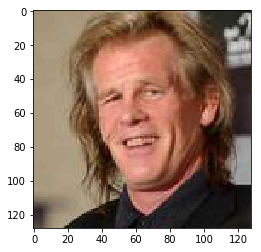

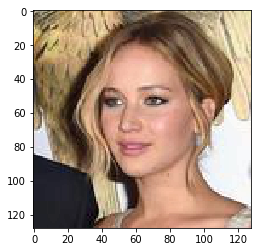

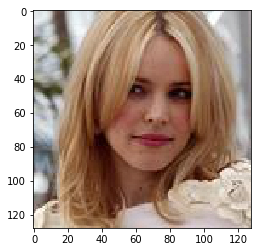

In [17]:
# plot some picture from it
# /1 needed to convert to float (with .astype(np.float32) lab2rgb gives error)
plt.imshow(lab2rgb(hdf_file['train'][100000]/1))
plt.show()
plt.imshow(lab2rgb(hdf_file['valid'][10000]/1))
plt.show()
plt.imshow(lab2rgb(hdf_file['test'][1000]/1))
plt.show()

In [20]:
hdf_file.close() # closing file